# 1D FDM - Axisymmetric Magnetostatics
Often, we wish to study axisymmetric problems (i.e., problems with rotational symmetry around a center axis). This can of course be done in two or three dimensions by just modelling the entire object. However, it can be interesting to _reduce_ the dimension of the problem by making use of the symmetries: this reduces the required computation power and can yield better convergence properties.

In this notebook we will study magnetostatics in an axisymmetric problem: _TODO configuration_. The relevant theory and differential equation will be derived, discretized using the finite-difference method, and implemented. Three examples with varying configurations are presented and explained.

# Theory
Below, the theory of 1D FDM magnetostatics is derived in [cylindrical coordinates](https://en.wikipedia.org/wiki/Cylindrical_coordinate_system), starting from Maxwell's equations. The differential equations are derived and discretized using a finite-difference method. The boundary conditions required for this axisymmetric study are also derived.

### Magnetoquasistatics
Under quasi-static conditions, the coupling between the electric and magnetic field is neglected. For the magnetic field this leaves the following equations:
$$ \left\{ \begin{array}{l}
    \nabla \times \mathbf{H} = \mathbf{J} \\
    \nabla \cdot \mathbf{B} = 0 \implies \mathbf{B} = \nabla \times \mathbf{A} \\
    \mathbf{B} = \mu \mathbf{H}
\end{array} \right. $$
where $\mathbf{H}$ is the magnetic field intensity in $\mathrm{[A/m]}$, $\mathbf{B}$ is the magnetic flux density in $\mathrm{[Wb/m^2]}$ or $\mathrm{[T]}$, $\mathbf{A}$ is the magnetic vector potential in $\mathrm{[Wb/m]}$, and $\mathbf{J}$ is the current density in $\mathrm{[A/m^2]}$. The two fields are related by the permeability $\mu$ with units $\mathrm{[H/m]}$.

Let $\nu = \frac{1}{\mu}$ be the reluctivity. Then we can solve for the magnetic vector potential $\mathbf{A}$ by combining the three equations:
\begin{align*}
    \nabla \times \mathbf{H} & = \mathbf{J} \\
    \nabla \times \left[ \frac{1}{\mu} \mathbf{B} \right] & = \mathbf{J} \\
    \nabla \times \left[ \nu \nabla \times \mathbf{A} \right] & = \mathbf{J}
\end{align*}

### Formulation in 1D Cylindrical Coordinates
Consider the geometry under investigation invariant in the $\phi$ and $z$ directions. Then the electrostatic equations given above can be written in terms of the radial distance $r$ only. The curl in cylindrical coordinates is elaborated [here](https://en.wikipedia.org/wiki/Cylindrical_coordinate_system).

Our first step towards formulating a differential equation that can be solved using a 1D FDM or FEM approach is the assumption that $\mathbf{A}$ and $\mathbf{J}$ are oriented along the positive $\phi$-axis, out of the screen. As a result, $\mathbf{B}$ and $\mathbf{H}$ are oriented along the $z$-axis. This assumption is validated [here](https://physics.stackexchange.com/questions/398957).
Using this, we can rewrite the curl equations in terms of their individual derivatives.
$$ \nabla \times \mathbf{A} = \frac{1}{r} \frac{\partial}{\partial r} \left[ r A_\phi \right] \hat{\mathbf{z}} $$
To make the following calculations easier, we substitute $u = \frac{A_\phi}{r}$, which results in
$$ \nabla \times \mathbf{A} = \frac{1}{r} \frac{\partial}{\partial r} \left[ r^2 A_\phi \right] = r \frac{\partial u}{\partial r} + 2u $$
Further filling in the rest of the equations, we find
\begin{align*}
    \nabla \times \mathbf{H} & = -\frac{\partial H_z}{\partial r} \hat{\mathbf{\phi}} \\
        & = -\frac{\partial}{\partial r} \left[ r \nu(r) \frac{\partial u}{\partial r} + 2 \nu(r) u \right] \hat{\mathbf{\phi}} = \mathbf{J} \\
        & \implies -\frac{\partial}{\partial r} \left[ r \nu(r) \frac{\partial u}{\partial r} \right] - 2 \frac{\partial}{\partial r} \left[ \nu(r) u \right] = J_\phi
\end{align*}


Generalizing this using $u(r) = \frac{A_\phi(r)}{r}$ as the unknown, $f(r) = -J_\phi(r)$ as the source current density, and $c(r) = \nu(r)$ as the generalized diffusion coefficient representing the magnetic reluctivity, we obtain
$$ \frac{\partial}{\partial r} \left[ r c(r) \frac{\partial u}{\partial r} \right] + 2 \frac{\partial}{\partial r} \left[ c(r) u \right] = f(r) $$

### Finite Difference Approximation
Discretizing the differential equation using the finite difference approximation, we obtain
$$\frac{1}{h^2}\left[ r_{i-0.5} c_{i-0.5} u_{i-1} - (r_{i+0.5} c_{i+0.5} + r_{i-0.5} c_{i-0.5}) u_i + r_{i+0.5} c_{i+0.5} u_{i+1} \right] + \frac{c_i}{h} \left[ u_{i-1} - u_{i+1} \right] = f_i$$
Writing this in matrix form we obtain
$$ A u = f \qquad A = B^T \operatorname{diag}(r) D B + 2 C E $$
where $D$ and $E$ are diagonal matrices describing $c(r)$ on the midpoints and mesh nodes respectively. $B$ is a matrix representing the single derivative on the midpoints, and $C$ is a matrix representing the single derivative on the mesh nodes.

### Boundary Conditions
For axisymmetric problems, a homogeneous Dirichlet condition must be applied at the axis of symmetry. _TODO why?_
$$ A_\phi(r = 0) = 0 $$
The value of $A_\phi$ at the outer boundary depends on the problem being simulated (e.g., a non-homogeneous condition might be supplied to model an external magnetic field). In this case, we will supply another homogenous Dirichlet condition.

### Post-processing
In post-processing, the magnetic vector potential, flux density, and flux can be obtained
\begin{align*}
    A_\phi & = r u \\
    B_z & = \frac{1}{r} \frac{\partial}{\partial r} (r A_\phi) = \frac{B (r A_\phi)}{r} \qquad \text{$B$ is derivative matrix} \\
    \Phi & = \int_{\partial S} \vec{A} \cdot d\vec{\ell} = 2\pi r A_\phi
\end{align*}

# Import packages

In [1]:
using LinearAlgebra
using Interpolations

using Plots
using LaTeXStrings

# Example 1: Coil in Air
Consider an air-core coil in space with a cross-section as shown in the figure below. A current is flowing through the windings in the $-\phi$ direction, which is into the screen (using the right-hand rule, we then know that the magnetic field will be oriented along the $+z$ axis).
In this first example, the relative magnetic permeability of all materials is kept at $\mu_r = 1$, which is approximately true for air and a non-ferrous conductor such as copper.

![Configuration for example 1](images/ms_ex1_config.svg)

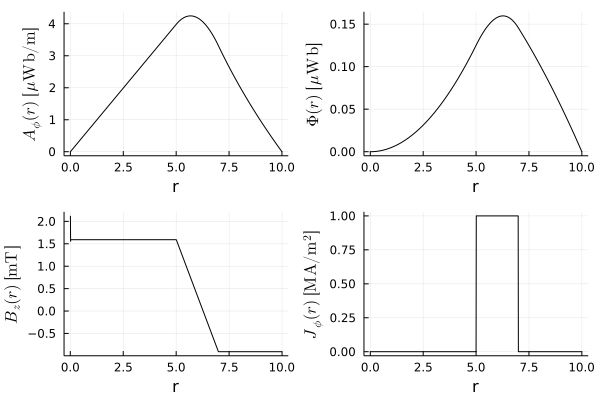

In [5]:
# Construct the 1D mesh
xmin = 0;
xmax = 10e-3;

N = 1000; Np1 = N+1; h = (xmax - xmin)/N; h2=h*h; 
x = Vector(xmin:h:xmax); 
xmid = x[1:end-1].+h/2; 

# Define source and material
f = 1e6 .* (x .< 7e-3) .* (5e-3 .< x);

mu0 = 4*pi*1e-7;
mu1 = 1e4*mu0;
mu(x) = mu0 .* ones(size(x));
D = mu(xmid);
E = mu(x);

D = 1 ./ D; E = 1 ./ E;

# Construct A and B matrices
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
C = 1/(2*h) * Tridiagonal(ones(N), zeros(N+1), -ones(N));

A  = BT*Diagonal(xmid.*D)*B + 2 * C * Diagonal(E); 

# Boundary conditions
A[1,:] = zeros(N+1);
A[1,1] = 1;            A[1,2] = 0;             f[1] = 0;   # A = 0: Axisymmetry
A[end,end-1] = 0;      A[end,end] = 1;         f[end] = 0; # A = 0 

# 
u   = A \ f;
u   = u .* x;
ux   = (B * (x .* u)) ./ xmid;

p1 = plot(x * 1e3, u * 1e6, color = :black, xlabel = "r", ylabel = L"A_{\phi}(r)\ [\mathrm{\mu Wb/m}]", legend = false);
p2 = plot(x * 1e3, 2*pi*x.*u * 1e6, color = :black, xlabel = "r", ylabel = L"\Phi(r)\ [\mathrm{\mu Wb}]", legend = false);
p3 = plot(xmid * 1e3, ux * 1e3, color = :black, xlabel = "r", ylabel = L"B_z(r)\ \mathrm{[mT]}", legend = false);
p4 = plot(x * 1e3, f * 1e-6, color = :black, xlabel = "r", ylabel = L"J_{\phi}(r)\ \mathrm{[MA/m^2]}", legend = false);

plot(p1, p2, p3, p4)

# Example 2: Coil with Core
Next, we place a magnetic core (i.e., a piece of material with $\mu_r \gg 1$) inside the coil, as shown in the image below. The current is still flowing in the winding in the $-\phi$ direction (into the screen).

![Configuration for example 2](images/ms_ex2_config.svg)

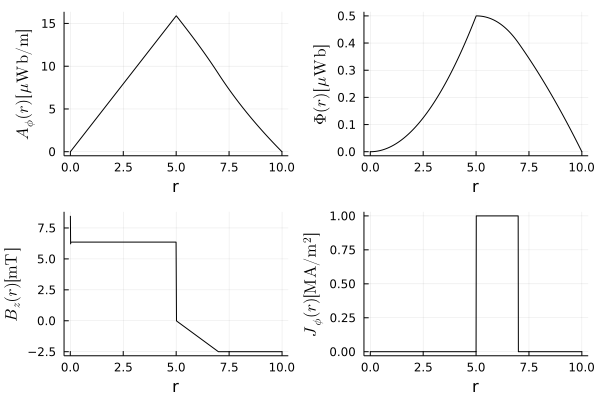

In [6]:
# Construct the 1D mesh
xmin = 0;
xmax = 10e-3;

N = 1000; Np1 = N+1; h = (xmax - xmin)/N; h2=h*h; 
x = Vector(xmin:h:xmax); 
xmid = x[1:end-1].+h/2; 

# Define source and material
f = 1e6 .* (x .< 7e-3) .* (5e-3 .< x);

mu0 = 4*pi*1e-7;
mu1 = 1e4*mu0;
mu(x) = mu0 .+ (mu1 - mu0) .* (x .> 0) - (mu1 - mu0) .* (x .> 5e-3);
D = mu(xmid);
E = mu(x);

D = 1 ./ D; E = 1 ./ E;

# Construct A and B matrices
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
C = 1/(2*h) * Tridiagonal(ones(N), zeros(N+1), -ones(N));

A  = BT*Diagonal(xmid.*D)*B + 2 * C * Diagonal(E); 

# Boundary conditions
A[1,:] = zeros(N+1);
A[1,1] = 1;            A[1,2] = 0;             f[1] = 0;   # A = 0: Axisymmetry
A[end,end-1] = 0;      A[end,end] = 1;         f[end] = 0; # A = 0 

# 
u   = A \ f;
u   = u .* x;
ux   = (B * (x .* u)) ./ xmid;

p1 = plot(x * 1e3, u * 1e6, color = :black, xlabel = "r", ylabel = L"A_{\phi}(r)\ [\mathrm{\mu Wb/m}]", legend = false);
p2 = plot(x * 1e3, 2*pi*x.*u * 1e6, color = :black, xlabel = "r", ylabel = L"\Phi(r)\ [\mathrm{\mu Wb}]", legend = false);
p3 = plot(xmid * 1e3, ux * 1e3, color = :black, xlabel = "r", ylabel = L"B_z(r)\ \mathrm{[mT]}", legend = false);
p4 = plot(x * 1e3, f * 1e-6, color = :black, xlabel = "r", ylabel = L"J_{\phi}(r)\ \mathrm{[MA/m^2]}", legend = false);

plot(p1, p2, p3, p4)

# Example 3: Coil with Core and Airgap

![Configuration for example 3](images/ms_ex3_config.svg)

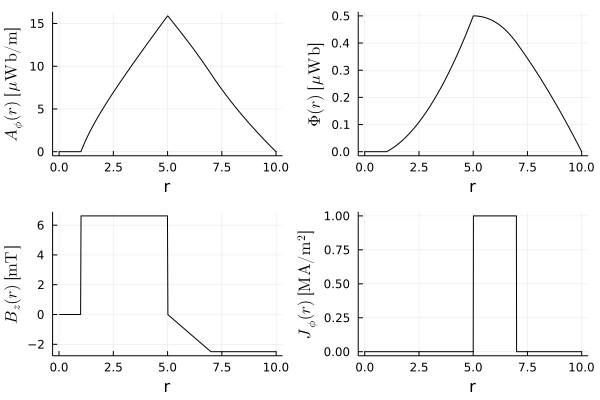

In [8]:
# Construct the 1D mesh
xmin = 0;
xmax = 10e-3;

N = 1000; Np1 = N+1; h = (xmax - xmin)/N; h2=h*h; 
x = Vector(xmin:h:xmax); 
xmid = x[1:end-1].+h/2; 

# Define source and material
f = 1e6 .* (x .< 7e-3) .* (5e-3 .< x);

mu0 = 4*pi*1e-7;
mu1 = 1e4*mu0;
D = mu0 .+ (mu1 - mu0) .* (xmid .> 1e-3) - (mu1 - mu0) .* (xmid .> 5e-3);
E = mu0 .+ (mu1 - mu0) .* (x .> 1e-3) - (mu1 - mu0) .* (x .> 5e-3);

D = 1 ./ D; E = 1 ./ E;

# Construct A and B matrices
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
C = 1/(2*h) * Tridiagonal(ones(N), zeros(N+1), -ones(N));

A  = BT*Diagonal(xmid.*D)*B + 2 * C * Diagonal(E); 

# Boundary conditions
A[1,:] = zeros(N+1);
A[1,1] = 1;            A[1,2] = 0;             f[1] = 0;   # A = 0: Axisymmetry
A[end,end-1] = 0;      A[end,end] = 1;         f[end] = 0; # A = 0

# 
u   = A \ f;
u   = u .* x;
ux   = (B * (x .* u)) ./ xmid;

p1 = plot(x * 1e3, u * 1e6, color = :black, xlabel = "r", ylabel = L"A_{\phi}(r)\ [\mathrm{\mu Wb/m}]", legend = false);
p2 = plot(x * 1e3, 2*pi*x.*u * 1e6, color = :black, xlabel = "r", ylabel = L"\Phi(r)\ [\mathrm{\mu Wb}]", legend = false);
p3 = plot(xmid * 1e3, ux * 1e3, color = :black, xlabel = "r", ylabel = L"B_z(r)\ \mathrm{[mT]}", legend = false);
p4 = plot(x * 1e3, f * 1e-6, color = :black, xlabel = "r", ylabel = L"J_{\phi}(r)\ \mathrm{[MA/m^2]}", legend = false);

plot(p1, p2, p3, p4)